In [ ]:
## imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from sklearn.naive_bayes import CategoricalNB
import numpy as np

import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
import random
from PIL import Image
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import kagglehub

pd.set_option('display.max_colwidth', None)
# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")


print("Path to dataset files:", path)

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


# Problem Definition & Motivation

We are using the dataset "Cards Image Dataset-Classification" with 7624 train images, 265 test images, and 265 validation images. 
https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification 

**Goal**
Build a model that, given a photo of a playing card, predicts which card it is (e.g. “ace of hearts”, “king of spades”, etc.).

**Why it’s interesting**:
- Real-world vision challenge: cards vary in orientation, lighting, occlusion, background clutter.
- Hierarchical structure: each card has a rank (A, 2…K) and a suit (♥, ♣, ♦, ♠).
- Can be framed as a flat 53-way classification or a multi‐output (rank + suit) problem.

**Dataset**:
- Stored in `train/`, `valid/`, `test/` subfolders, one folder per class (e.g. `ace of hearts`, `two of spades`, …, `joker`).

We first want to load our dataset into our project. We can see the train, validation, and test folders.

## Preprocessing

In [ ]:
# Imports and dataset path
from pathlib import Path

# Adjust this path to wherever you unpacked the dataset
DATA_ROOT = Path('/home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2')

train_dir = DATA_ROOT / 'train'
valid_dir = DATA_ROOT / 'valid'
test_dir  = DATA_ROOT / 'test'

print("Train folder:", train_dir.resolve())
print("Valid folder:", valid_dir.resolve())
print("Test  folder:", test_dir.resolve())

Train folder: /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train
Valid folder: /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid
Test  folder: /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test


Now we want to view all the different types of cards we have to get an understanding of the types of cards within each folder.

In [ ]:
# List unique classes in the training folder
train_classes = [folder.name for folder in train_dir.iterdir()
                 if folder.is_dir()]
print(f"Unique classes in the training folder ({len(train_classes)}):")
for card_class in train_classes:
    print(card_class)

Unique classes in the training folder (53):
joker
ace_of_clubs
ace_of_diamonds
ace_of_hearts
ace_of_spades
eight_of_clubs
eight_of_diamonds
eight_of_hearts
eight_of_spades
five_of_clubs
five_of_diamonds
five_of_hearts
five_of_spades
four_of_clubs
four_of_diamonds
four_of_hearts
four_of_spades
jack_of_clubs
jack_of_diamonds
jack_of_hearts
jack_of_spades
king_of_clubs
king_of_diamonds
king_of_hearts
king_of_spades
nine_of_clubs
nine_of_diamonds
nine_of_hearts
nine_of_spades
queen_of_clubs
queen_of_diamonds
queen_of_hearts
queen_of_spades
seven_of_clubs
seven_of_diamonds
seven_of_hearts
seven_of_spades
six_of_clubs
six_of_diamonds
six_of_hearts
six_of_spades
ten_of_clubs
ten_of_diamonds
ten_of_hearts
ten_of_spades
three_of_clubs
three_of_diamonds
three_of_hearts
three_of_spades
two_of_clubs
two_of_diamonds
two_of_hearts
two_of_spades


We noticed that each class type has a folder with a space in the text. For example, "ace of spades" has two spaces. When converting this dataset into our own dataframe, these spaces cause issues. 

Our next preocessing step is to replace each of the spaces of the folders with underscores to easily access the images with no problem.

In [ ]:
import os

# Update folder names to replace spaces with underscores

def update_folder_names(directory):
    for folder in os.listdir(directory):
        if ' ' in folder:
            old_path = os.path.join(directory, folder)
            new_folder_name = folder.replace(' ', '_')
            new_path = os.path.join(directory, new_folder_name)
            os.rename(old_path, new_path)
            # print(f"Renamed folder: {folder} → {new_folder_name}")


# Apply the function to train, valid, and test directories
update_folder_names(train_dir)
update_folder_names(valid_dir)
update_folder_names(test_dir)

For our pre-processing, we aim to use the traditional deck of cards (Diamond, Club, Spade, Hearts, and cards numbers from 2-10, Jack, Queen, King, Ace)

Therefore, we will drop the Joker class to focus our machine learning model methods.

In a real world environment, this model would help with individuals in the casino/gambling industry for identifying cards efficiently.

We will first create a dataframe with the file paths from before, and then remove the Joker class. 

In [ ]:
# Function to create a DataFrame with file paths and labels
def create_dataframe(directory):
    data = []
    for folder in directory.iterdir():
        if folder.is_dir():
            label = folder.name
            # Assuming images are in JPG format
            for file in folder.glob("*.jpg"):
                data.append({"file_path": str(file), "label": label})
    return pd.DataFrame(data)


# Load the dataset into DataFrames
train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)

# Remove the Joker class from the DataFrames
train_df = train_df[train_df["label"] != "joker"]
valid_df = valid_df[valid_df["label"] != "joker"]
test_df = test_df[test_df["label"] != "joker"]


# Display the first few rows of the training DataFrame
print("Training DataFrame:")
print(train_df.head())

# Display unique classes in train_df
unique_classes = train_df["label"].unique()
print(f"Unique classes in train_df ({len(unique_classes)}):")
for card_class in unique_classes:
    print(card_class)

Training DataFrame:
                                                                                                                    file_path  \
115  /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train/ace_of_clubs/001.jpg   
116  /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train/ace_of_clubs/002.jpg   
117  /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train/ace_of_clubs/003.jpg   
118  /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train/ace_of_clubs/004.jpg   
119  /home/vscode/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train/ace_of_clubs/005.jpg   

            label  
115  ace_of_clubs  
116  ace_of_clubs  
117  ace_of_clubs  
118  ace_of_clubs  
119  ace_of_clubs  
Unique classes in train_df (52):
ace_of_clubs
ace_of_diamonds
ace_of_hearts
ace_of_sp

## Exploratory Data Analysis

We will now view the train/test/validation split with the dataframe and display it in a tabular format.

In [ ]:
# Function to print train/test/validation split metadata
def print_train_test_valid_amounts(train_data, test_data, valid_data):
    print("\nThe Train/Test/Validation Split:\n--------------------------------")
    train_count = len(train_data)
    print("# of Train Images:", train_count)

    test_count = len(test_data)
    print("# of Test Images:", test_count)

    valid_count = len(valid_data)
    print("# of Validation Images:", valid_count)

    total_count = train_count + test_count + valid_count
    train_ratio = np.round(train_count / total_count, 2)
    test_ratio = np.round(test_count / total_count, 2)
    valid_ratio = np.round(valid_count / total_count, 2)

    print("Train/Test/Validation Ratios:", train_ratio,
          "/", test_ratio, "/", valid_ratio)


# Call the function with train_df, test_df, and valid_df
print_train_test_valid_amounts(train_df, test_df, valid_df)

# Show the amount in each class for the train data
print("\nAmount of Cards in Each Class - Train:\n---------------------------------------")
train_class_amts = train_df['label'].value_counts()

for ind, card, amount in zip(range(0, len(train_class_amts)), train_class_amts.index, train_class_amts):
    print(f'{ind + 1:02}.', card, '\t', amount)

train_count = len(train_df)
print('\nTotal\t\t\t', train_count)

num_classes = len(train_df['label'].unique())
print(f"\nThere are {num_classes} different card classes")


The Train/Test/Validation Split:
--------------------------------
# of Train Images: 7509
# of Test Images: 260
# of Validation Images: 260
Train/Test/Validation Ratios: 0.94 / 0.03 / 0.03

Amount of Cards in Each Class - Train:
---------------------------------------
01. ace_of_spades 	 181
02. jack_of_spades 	 172
03. jack_of_clubs 	 171
04. ace_of_hearts 	 171
05. jack_of_hearts 	 168
06. seven_of_spades 	 165
07. queen_of_diamonds 	 163
08. queen_of_spades 	 162
09. queen_of_clubs 	 161
10. jack_of_diamonds 	 160
11. eight_of_diamonds 	 159
12. six_of_spades 	 158
13. ten_of_spades 	 158
14. five_of_spades 	 158
15. four_of_clubs 	 157
16. two_of_spades 	 155
17. two_of_hearts 	 155
18. nine_of_spades 	 154
19. four_of_hearts 	 154
20. three_of_diamonds 	 153
21. six_of_clubs 	 152
22. eight_of_hearts 	 152
23. king_of_spades 	 151
24. ten_of_diamonds 	 151
25. five_of_clubs 	 150
26. seven_of_hearts 	 143
27. three_of_spades 	 142
28. ten_of_clubs 	 141
29. four_of_spades 	 140
3

We now can see the train/test/validation split based on the number of images that are allocated to each split type.

We want to view some examples of the cards and their respective labels to get an understanding of the different types of images that are in our dataset.

IndexError: index 12 is out of bounds for axis 0 with size 12

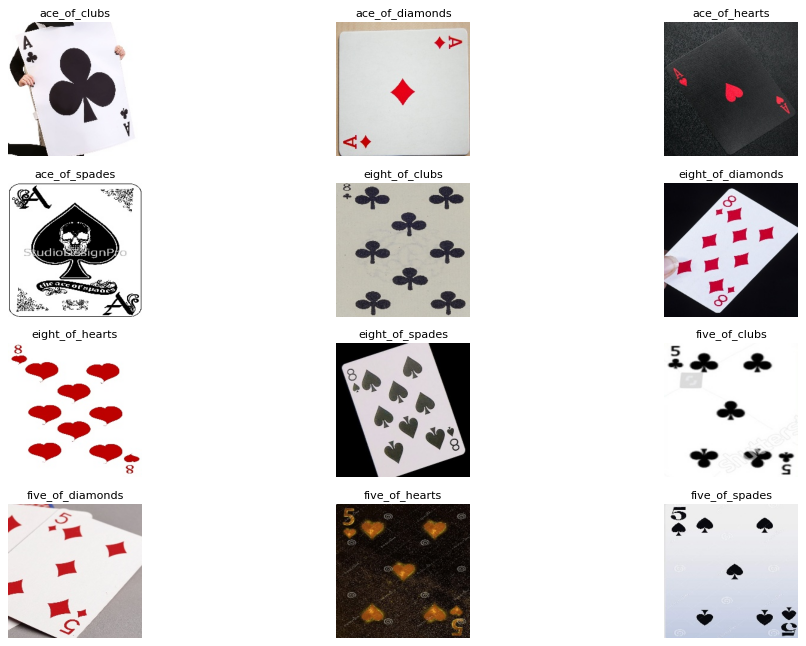

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image


def display_one_per_face_value(train_df):
    """
    Displays one image per face value (e.g., ace, five, eight) from train_df.
    Assumes train_df has columns: [file_path, label] where label is like 'ace of hearts'.
    """
    face_value_to_row = {}

    # Collect one card per face value
    for _, row in train_df.iterrows():
        label = row['label']
        face_value = label.split(" of ")[0]
        if face_value not in face_value_to_row:
            face_value_to_row[face_value] = row

    # Ensure we only have 13 cards
    selected_cards = list(face_value_to_row.values())[:13]

    # Create a 4x3 grid (4 rows, 3 columns)
    fig, axs = plt.subplots(4, 3, figsize=(15, 10), dpi=80)
    axs = axs.flatten()  # Flatten the grid for easier indexing

    for i, row in enumerate(selected_cards):
        img = Image.open(row['file_path'])
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"{row['label']}", fontsize=10)

    # Hide any unused subplots
    for j in range(len(selected_cards), len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


# Call the function with train_df
display_one_per_face_value(train_df)

Assign X_train, X_test, X_val, Y_train, Y_test, and Y_val to our train/test/validation split dataframes.

As of right now, our data is all with file paths, so we need to make an array with the image data.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images and convert them to arrays


def load_images(file_paths, target_size=(224, 224)):
    image_data = []
    for file_path in file_paths:
        # Load image and resize
        img = load_img(file_path, target_size=target_size)
        img_array = img_to_array(img)  # Convert image to array
        image_data.append(img_array)
    return np.array(image_data)


# Create image arrays for train, test, and validation sets
X_train = load_images(train_df['file_path'].values)
X_test = load_images(test_df['file_path'].values)
X_val = load_images(valid_df['file_path'].values)

# Extract labels
y_train = train_df['label'].values
y_test = test_df['label'].values
y_val = valid_df['label'].values

# Print shapes of the arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

X_train shape: (7509, 224, 224, 3)
X_test shape: (260, 224, 224, 3)
X_val shape: (260, 224, 224, 3)
y_train shape: (7509,)
y_test shape: (260,)
y_val shape: (260,)


Given this information, we were able to extract the shape of `X_train`, `X_test`, `X_val`. These three variables hold the image data, and we can see the shape clearly where the images are 224x224x3. For `y_train`, `y_test`, and `y_val`, they hold the labels of each image which we will use for predictions. 

Our next step is to perform label encoding on `y_train`, `y_test`, and `y_val`.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# create a data frame to store these encoded labels,
# as we'll need to refer to the original class labels later

encoded_dict = pd.DataFrame(
    {'train_labels': y_train, 'train_encoded_labels': y_train_encoded})
encoded_dict = encoded_dict.groupby(
    'train_labels')['train_encoded_labels'].mean().reset_index()
encoded_dict['train_encoded_labels'] = encoded_dict['train_encoded_labels'].astype(
    'int')

print("Encoded class labels and their corresponding class name:")
encoded_dict

Encoded class labels and their corresponding class name:


,train_labels,train_encoded_labels
0,ace_of_clubs,0
1,ace_of_diamonds,1
2,ace_of_hearts,2
3,ace_of_spades,3
4,eight_of_clubs,4
5,eight_of_diamonds,5
6,eight_of_hearts,6
7,eight_of_spades,7
8,five_of_clubs,8
9,five_of_diamonds,9
